### Personalized Medicine: Redefining Cancer Treatment
https://www.kaggle.com/c/msk-redefining-cancer-treatment

###### Problem Statment : Idenitfy the type of Cancer Class from  1-9 based on the Gene , Variation and related text provided

In [3]:
# Loading all required packages

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


In [4]:
# import data
data_variants = pd.read_csv('training/training_variants')
data_text = pd.read_csv('training/training_text',sep="\|\|",engine="python", names=["ID","TEXT"], skiprows=1)

In [5]:
data_text.head()

ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...

In [6]:
data_variants.head()

ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4

In [7]:
data_variants.describe()

ID        Class
count  3321.000000  3321.000000
mean   1660.000000     4.365854
std     958.834449     2.309781
min       0.000000     1.000000
25%     830.000000     2.000000
50%    1660.000000     4.000000
75%    2490.000000     7.000000
max    3320.000000     9.000000

In [8]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


No missing data in data_variants

In [9]:
print(data_text.describe())
print('*'* 50)
print(data_text.info())

                ID
count  3321.000000
mean   1660.000000
std     958.834449
min       0.000000
25%     830.000000
50%    1660.000000
75%    2490.000000
max    3320.000000
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB
None


In [10]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [11]:
def refine_text(x):
    string = ""
    x = re.sub('[^a-zA-Z0-9\n]', ' ', str(x))
    x = re.sub('\s+', ' ', str(x))
    x = x.lower()
    
    for i in x.split():
        if i not in stop_words:
            string += i + " "
    return string

In [12]:
data_text['TEXT'] = data_text['TEXT'].apply(refine_text)

In [13]:
data_text.head()

ID                                               TEXT
0   0  cyclin dependent kinases cdks regulate variety...
1   1  abstract background non small cell lung cancer...
2   2  abstract background non small cell lung cancer...
3   3  recent evidence demonstrated acquired uniparen...
4   4  oncogenic mutations monomeric casitas b lineag...

In [14]:
data = pd.merge(data_variants,data_text,on='ID', how='left' )

In [15]:
data.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                TEXT  
0  cyclin dependent kinases cdks regulate variety...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evidence demonstrated acquired uniparen...  
4  oncogenic mutations monomeric casitas b lineag...

In [16]:
pandas_profiling.ProfileReport(data)
data.profile_report()

In [17]:
data.columns

Index(['ID', 'Gene', 'Variation', 'Class', 'TEXT'], dtype='object')

In [18]:
data = data[['ID', 'Gene', 'Variation', 'TEXT','Class']]
data.head()

ID    Gene             Variation  \
0   0  FAM58A  Truncating Mutations   
1   1     CBL                 W802*   
2   2     CBL                 Q249E   
3   3     CBL                 N454D   
4   4     CBL                 L399V   

                                                TEXT  Class  
0  cyclin dependent kinases cdks regulate variety...      1  
1  abstract background non small cell lung cancer...      2  
2  abstract background non small cell lung cancer...      2  
3  recent evidence demonstrated acquired uniparen...      3  
4  oncogenic mutations monomeric casitas b lineag...      4

In [19]:
data.rename(columns = {"TEXT": "Text"}, inplace=True) 

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Text         3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


### EDA

#### Variable Identification
* Predicter & Target variable
* Charecter & Numerical Datatypes
* Categorical & Continious

#### Predicter & Target variable

* Predictor variables are 'ID', 'Gene', 'Variation', 'Text'.
* Target variable is Class

#### Charecter & Numerical Datatypes
* Charecter Datatypes are 'Gene', 'Variation', 'Text',.
* Numerical Datatypes are 'ID', 'Class'

#### Categorical & Continious
* Categorical Variables are 'Gene', 'Variation', 'Text', 'Class'.
* Continious Datatypes are 'ID'

#### Univariate Analysis
* Categorical variables - count plot
           * frequency Count
* Numerical Variables - Histogram & Boxplot
           * central tendency - Mean, Median, Mode - Skewness - Histogram
           * spread of the variable - Vaiance, IQR - Boxplot

In [21]:
for i in data.columns:
    print(i, data[i].nunique())

ID 3321
Gene 264
Variation 2996
Text 1921
Class 9


#### Analysis : Questions

* Each gene can have multiple variaions
* Can same variaion present in different genes ?
* 2996 unique Variation in 3321 records & 1920 unique Texts in 3316 records. so, there are some duplicates. 
* Were the duplicates in Varaition and text in the same gene / class ?

#### Univariate Analysis - Target

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64


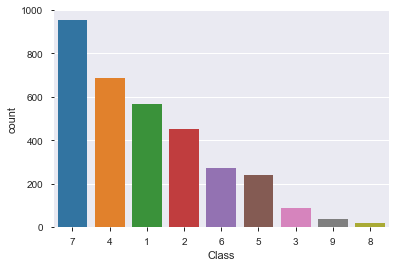

In [22]:
print(data['Class'].value_counts())
sns.countplot(data['Class'], order=data['Class'].value_counts().index)

##### Target Analysis:
* More number of variations belongs to the class 7 and least to the class 8

In [23]:
df_gene = data['Gene'].value_counts().rename_axis('Gene').reset_index(name='counts')
print (df_gene.head(5))

    Gene  counts
0  BRCA1     264
1   TP53     163
2   EGFR     141
3   PTEN     126
4  BRCA2     125


    Gene  counts
0  BRCA1     264
1   TP53     163
2   EGFR     141
3   PTEN     126
4  BRCA2     125
**************************************************
       Gene  counts
259  INPP4B       1
260    IL7R       1
261    PAK1       1
262   DUSP4       1
263    SHQ1       1


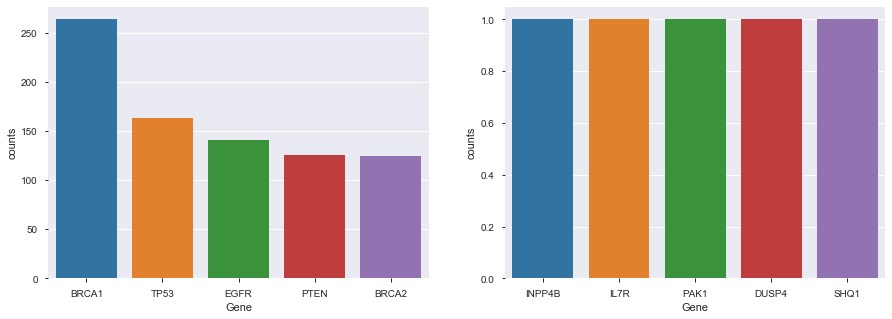

In [24]:
#select top 5 & last 5 Genes

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
print(df_gene.iloc[0:5,:])
sns.barplot(x = 'Gene', y = 'counts', data = df_gene.iloc[0:5,:])
#plt.show()
print('*' * 50 )
plt.subplot(1,2,2)
print(df_gene.iloc[-5:,:])
sns.barplot(x = 'Gene', y = 'counts', data = df_gene.iloc[-5:,:])
plt.show()

In [25]:
top_genes = data['Gene'].value_counts().head().index.tolist()
print( 'Here are the top most genes {}'.format(','.join(top_genes)))

Here are the top most genes BRCA1,TP53,EGFR,PTEN,BRCA2


In [26]:
df_var = data['Variation'].value_counts().rename_axis('Variation').reset_index(name='counts')
print(df_var.head())

              Variation  counts
0  Truncating Mutations      93
1              Deletion      74
2         Amplification      71
3               Fusions      34
4        Overexpression       6


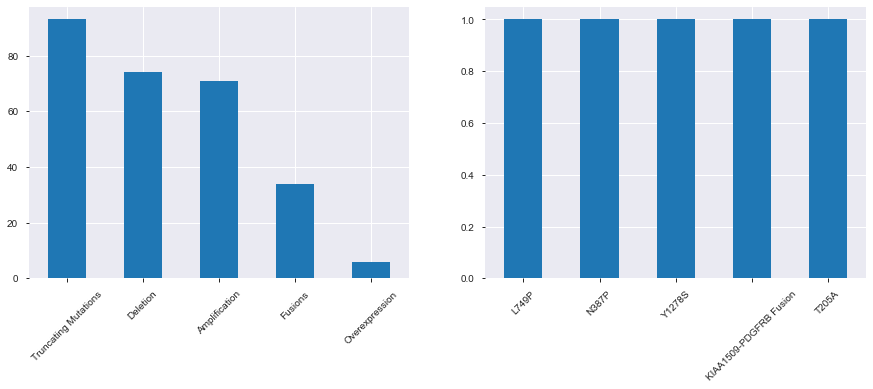

In [27]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
data['Variation'].value_counts().head(5).plot(kind='bar',rot=45)
plt.subplot(1,2,2)
data['Variation'].value_counts().tail(5).plot(kind='bar',rot=45)

In [28]:
top_var = data['Variation'].value_counts().head().index.tolist()
print( 'Here are the top most variations are {}'.format(', '.join(top_var)))

Here are the top most variations are Truncating Mutations, Deletion, Amplification, Fusions, Overexpression


### Q: Can same variaion present in different genes ?

In [29]:
data.groupby('Variation')['Gene'].count().sort_values(ascending= False).head()

Variation
Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
Name: Gene, dtype: int64

In [30]:
data[data['Variation'] == 'Overexpression'][['Gene','Variation']]

Gene       Variation
87    CCNE1  Overexpression
612   AURKB  Overexpression
960   KDM5C  Overexpression
1087   EZH2  Overexpression
1133    MET  Overexpression
1820   RHOA  Overexpression

##### Yes, same variation is present in different genes. Truncating Mutations  is present in  93 & Overexpression in  6 genes

### Q: Were the duplicates in Varaition in the same gene / class ?

In [31]:
var_dupli = data[data.duplicated(['Variation'])].sort_values(by=['Variation'])
var_dupli.head()

ID   Gene      Variation  \
3133  3133   KRAS          A146T   
3136  3136   KRAS          A146V   
1794  1794     AR  Amplification   
807    807  ERCC2  Amplification   
778    778  ERBB3  Amplification   

                                                   Text  Class  
3133  transforming mutations nras kras thought play ...      7  
3136  effect series mutations transforming potential...      7  
1794  overexpression amplified genes often associate...      7  
807   introduction platinum based chemotherapy stand...      2  
778   abstract her3 member egfr erbb receptor family...      7

In [32]:
var_analysis = data.groupby(['Variation'])[['Gene', 'Class']].nunique().sort_values(by='Gene', ascending = False).head()
var_analysis

Gene  Class
Variation                        
Truncating Mutations    93      4
Deletion                74      3
Amplification           71      3
Fusions                 34      3
Overexpression           6      2

In [33]:
data[data['Variation'] == 'Overexpression']

ID   Gene       Variation  \
87      87  CCNE1  Overexpression   
612    612  AURKB  Overexpression   
960    960  KDM5C  Overexpression   
1087  1087   EZH2  Overexpression   
1133  1133    MET  Overexpression   
1820  1820   RHOA  Overexpression   

                                                   Text  Class  
87    variety results point transcription factor e2f...      7  
612   cancers arise owing mutations subset genes con...      2  
960   currently prognostic factors available predict...      2  
1087  ezh2 member polycomb group genes important cel...      7  
1133  background c met protooncogene encodes met pro...      7  
1820  abstract adhesion tumor cells host cell layers...      7

In [34]:
var_list = var_analysis.index.tolist()
print('Most of variation types are {}'.format(', '.join(var_list)))

Most of variation types are Truncating Mutations, Deletion, Amplification, Fusions, Overexpression


##### Same Variation can be different Genes and different classes. For Example Overexpression variation is seen on 6 different genes and 2 types of calsses

Following are the Variation types that has more gene are Truncating Mutations, Deletion, Amplification


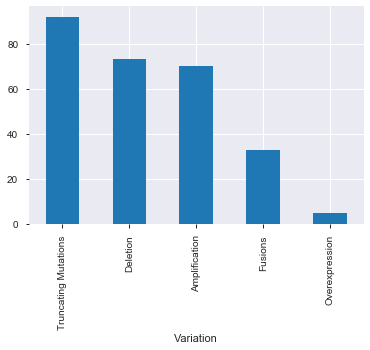

In [35]:
#  how many genes for each variaion type

a = var_dupli.groupby('Variation')['Gene'].nunique().sort_values(ascending=False).head(5)
a.plot(kind='bar')
var_list = a[a>50].index.tolist()
print('Following are the Variation types that has more gene are {}'.format(', '.join(var_list)))

### Q: Were the duplicates in Text in the same gene / class ?

In [36]:
# Find duplicate text

text_dupli = data[data.duplicated(['Text'])].sort_values(by = 'Text')
text_dupli.head(10)

ID    Gene          Variation  \
2331  2331    JAK2       N542_E543del   
2345  2345    JAK2              H538Q   
2768  2768    BRAF              T599I   
2705  2705    BRAF              N581S   
2756  2756    BRAF              E586K   
1685  1685    FLT3              D839G   
280    280  NKX2-1  TRB-NKX2-1 Fusion   
283    283  NKX2-1  TRA-NKX2-1 Fusion   
282    282  NKX2-1            Fusions   
1000  1000    TSC1              H105R   

                                                   Text  Class  
2331  2 mutation resulted myeloproliferative phenoty...      7  
2345  2 mutation resulted myeloproliferative phenoty...      7  
2768  30 mutations b raf gene associated human cance...      7  
2705  30 mutations b raf gene associated human cance...      2  
2756  30 mutations b raf gene associated human cance...      7  
1685  30 patients acute myeloid leukemia aml harbour...      7  
280   40 pediatric cases underlying oncogenic rearra...      2  
283   40 pediatric cases underlying oncogenic rearra...      2  
282   40 pediatric cases underlying oncogenic rearra...      2  
1000  50 transitional cell carcinomas bladder show l...      4

In [110]:
data[data.duplicated(['Text'])]

ID   Gene Variation  \
2        2    CBL     Q249E   
5        5    CBL     V391I   
6        6    CBL     V430M   
10      10    CBL     P395A   
13      13    CBL     C381A   
...    ...    ...       ...   
3305  3305  RUNX1  S70fsX93   
3309  3309  RUNX1     D171G   
3313  3313  RUNX1      H78Q   
3317  3317  RUNX1     A122*   
3320  3320  RUNX1      K83E   

                                                   Text  Class  
2     abstract background non small cell lung cancer...      2  
5     oncogenic mutations monomeric casitas b lineag...      4  
6     oncogenic mutations monomeric casitas b lineag...      5  
10    oncogenic mutations monomeric casitas b lineag...      4  
13    noonan syndrome autosomal dominant congenital ...      4  
...                                                 ...    ...  
3305  introduction myelodysplastic syndromes mds het...      4  
3309  bcr abl fusion protein generated 9 22 q34 q11 ...      1  
3313  bcr abl fusion protein generated 9 22 q34 q11 ...      4  
3317  introduction myelodysplastic syndromes mds het...      1  
3320  frequent mutations associated leukemia recurre...      4  

[1400 rows x 5 columns]

In [37]:
data.groupby('Text')['Gene', 'Variation', 'Class'].nunique().sort_values(by='Class', ascending = False).iloc[0,:]

Gene         1
Variation    8
Class        5
Name: activating mutations platelet derived growth factor pdgf receptor alpha pdgfra described patients gastrointestinal stromal tumors myeloid malignancies associated hypereosinophilia patients respond well imatinib mesylate raising question whether patients pdgf receptor mutation tumor types receive tyrosine kinase inhibitor treatment characterized 10 novel somatic point mutations pdgfra reported isolated cases glioblastoma melanoma acute myeloid leukemia peripheral nerve sheath tumors neuroendocrine carcinoma pdgfra transmembrane domain mutation v536e stimulated ba f3 cell growth signaling via erk stat5 absence ligand mutant identified glioblastoma strongly inhibited imatinib modeling suggested mutation modulates packing transmembrane domain helices receptor dimer contrast two mutations highly conserved residues affected receptor traffic cell surface kinase activity thereby preventing response pdgf mutations significant impact receptor ac

In [38]:
data.groupby('Text')['Gene', 'Variation', 'Class'].nunique().sort_values(by='Gene', ascending = False).iloc[0,:]

Gene         5
Variation    5
Class        3
Name: nan , dtype: int64

##### Same Text is present for Different Genes,Variations and Class. For example, "Cancer Genome ---"Text present for 4 genes 9 variaions and 3 classes

### Bi-variate Analysis
* Categorical & Categorical - Two-way Tables are Cross-tab, Pivot table - Stacked Chart  | Chi-Square Test
* Categorical & Continuous - Boxplot |  Z-test, T-test or ANOVA
* Continuous & Continuous - Scatter plot | Correlation"

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Text         3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(3)
memory usage: 315.7+ KB


In [40]:
pd.crosstab(index=data['Gene'], columns=data['Class']).head()

Class  1   2  3  4  5  6   7  8  9
Gene                              
ABL1   0  24  0  0  0  0   2  0  0
ACVR1  0   1  0  0  0  0   2  0  0
AGO2   4   1  0  0  0  0   0  0  0
AKT1   0   3  3  0  3  0  17  2  0
AKT2   0   1  0  0  0  0   8  0  2

In [41]:
data.groupby('Variation')['Gene'].count().sort_values(ascending= False).head()

Variation
Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
Name: Gene, dtype: int64

In [42]:
# Which gene is present in most classes

data.groupby('Gene')['Class'].nunique().sort_values(ascending=False).iloc[0:3]

Gene
EGFR     8
ERBB2    7
TP53     7
Name: Class, dtype: int64

Class  1   2  3  4  5  6   7  8
Gene                           
EGFR   1  45  1  5  3  1  84  1


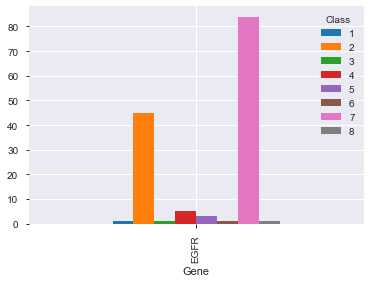

In [43]:
EGFR_gene = data[data['Gene']=='EGFR'][['Gene','Class']]
EGFR_gene_ct = pd.crosstab(index=EGFR_gene['Gene'], columns=EGFR_gene['Class'])
print(EGFR_gene_ct)
EGFR_gene_ct.plot(kind='bar')

In [131]:
data.pivot_table(index='Gene', values = 'Class', aggfunc=np.sum).sort_values(by= 'Class', ascending=False).head()

Class
Gene        
BRCA1   1057
EGFR     731
BRCA2    634
PTEN     495
BRAF     467

In [135]:
data.groupby('Gene')['Class'].sum().sort_values(ascending=False)

Gene
BRCA1       1057
EGFR         731
BRCA2        634
PTEN         495
BRAF         467
            ... 
RNF43          1
SHQ1           1
HIST1H1C       1
HLA-B          1
ATR            1
Name: Class, Length: 264, dtype: int64

In [45]:
data[data['Gene'] == 'U2AF1']

ID   Gene Variation  \
1151  1151  U2AF1      S34F   
1152  1152  U2AF1     Q157P   
1153  1153  U2AF1      S34Y   

                                                   Text  Class  
1151  heterozygous somatic mutations spliceosome gen...      9  
1152  whole exome sequencing studies identified comm...      9  
1153  abstract myelodysplastic syndromes mds hematop...      9

##### EGFR  Gene is present in 8 classes

#### EDA - Analysis

* Target Analysis: More number of variations belongs to the class 7 and least to the class 8
* Most of the variations present in the following genes BRCA1, TP53, EGFR, PTEN, BRCA2
* Top variation types are Truncating Mutations, Deletion, Amplification, Fusions, Overexpression
* Same type of variation is present in different genes and different classes.
* Same Text is present for Different Genes,Variations and Class
* EGFR Gene is present in 8 classes

#### Data Pre-processing

##### Replace spaces with _ in Gene & Variation Columns

In [46]:
def replace_space(val):
    return re.sub('\s+', '_', str(val))

In [47]:
data['Gene'] = data['Gene'].apply(replace_space)
data['Variation'] = data['Variation'].apply(replace_space)

##### Treating missing values

In [48]:
data.isnull().sum()

ID           0
Gene         0
Variation    0
Text         0
Class        0
dtype: int64

In [49]:
text_null = data[data['Text'].isnull()].index
text_null

Int64Index([], dtype='int64')

In [50]:
data['Text'].loc[text_null] = data.loc[text_null]['Gene']+ '_'+  data.loc[text_null]['Variation']

In [51]:
data.loc[text_null]

Empty DataFrame
Columns: [ID, Gene, Variation, Text, Class]
Index: []

In [52]:
data.isnull().sum()

ID           0
Gene         0
Variation    0
Text         0
Class        0
dtype: int64

* After Pre-processing No whitespaces in Gene, Variation Columns
* No null values

### Machine Learning

#### Split the data to train, CV and test

In [53]:
data.columns

Index(['ID', 'Gene', 'Variation', 'Text', 'Class'], dtype='object')

In [54]:
X = data[['ID', 'Gene', 'Variation', 'Text','Class']]
y = data['Class'].values

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
# Splitting the data into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Splitting the training data into train and cv
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [57]:
print('Shape of the X_train', X_train.shape[0])
print('Shape of the X_test', X_test.shape[0])
print('Shape of the X_cv', X_cv.shape[0])

Shape of the X_train 2124
Shape of the X_test 665
Shape of the X_cv 532


In [58]:
y_train

array([7, 4, 4, ..., 7, 2, 1], dtype=int64)

In [59]:
df_tn = pd.DataFrame({'y_train':y_train})
df_ts = pd.DataFrame({'y_test':y_test})
df_cv = pd.DataFrame({'y_cv':y_cv})

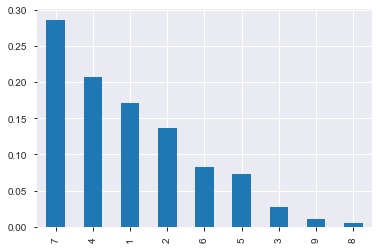

In [60]:
df_tn['y_train'].value_counts(normalize = True).plot(kind='bar')

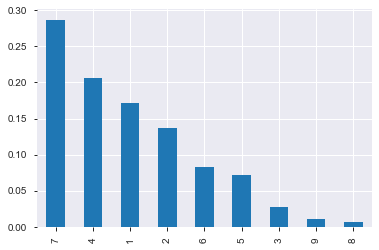

In [61]:
df_ts['y_test'].value_counts(normalize = True).plot(kind='bar')

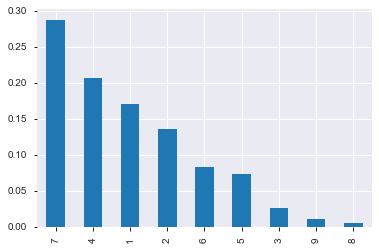

In [62]:
df_cv['y_cv'].value_counts(normalize = True).plot(kind='bar')

* __X_train, y_train__
* __X_cv, y_cv__
* __X_test, y_test__

#### Building a Random model

###### Log Loss for CV

In [63]:
cv_rows = X_cv.shape[0]
cv_pred_y = np.zeros((cv_rows,9))
for i in range(cv_rows):
    randam_num = np.random.rand(1,9)
    cv_pred_y[i] = randam_num/sum(sum(randam_num))
    
print("Log Loss for cv is ", (log_loss(y_cv,cv_pred_y, eps=1e-15)))

Log Loss for cv is  2.5123132815375677


In [137]:
cv_pred_y.shape

(532, 9)

In [138]:
y_cv.shape

(532,)

###### Log Loss for Test

In [64]:
test_rows = X_test.shape[0]

test_pred_y = np.zeros((test_rows,9))
for i in range(test_rows):
    random_numb = np.random.rand(1,9)
    test_pred_y[i] = ((random_numb/sum(sum(random_numb)))[0])
print("Log loss of test is", (log_loss(y_test,test_pred_y, eps=1e-15)))

Log loss of test is 2.475075515139763


In [65]:
predicted_y =np.argmax(test_pred_y, axis=1)
predicted_y

array([6, 0, 2, 4, 2, 8, 4, 5, 1, 2, 2, 0, 6, 8, 1, 8, 1, 8, 7, 7, 3, 6,
       4, 5, 7, 3, 8, 1, 4, 2, 6, 8, 4, 0, 8, 3, 6, 6, 0, 0, 8, 5, 0, 7,
       7, 0, 7, 7, 3, 5, 1, 2, 3, 2, 0, 0, 1, 4, 1, 8, 6, 3, 0, 4, 7, 5,
       1, 6, 6, 2, 6, 5, 5, 2, 7, 3, 0, 3, 3, 8, 3, 0, 2, 1, 3, 1, 4, 1,
       3, 2, 7, 0, 2, 0, 7, 8, 3, 7, 4, 7, 4, 7, 5, 4, 7, 2, 6, 6, 8, 1,
       0, 5, 1, 2, 1, 2, 4, 2, 4, 7, 0, 8, 6, 2, 2, 0, 6, 5, 0, 2, 7, 0,
       4, 6, 6, 2, 4, 0, 7, 5, 1, 7, 4, 1, 0, 0, 6, 8, 5, 4, 8, 3, 6, 4,
       5, 7, 8, 0, 5, 2, 8, 6, 5, 6, 7, 8, 8, 2, 2, 5, 6, 4, 6, 2, 0, 0,
       8, 0, 8, 0, 8, 7, 6, 2, 5, 3, 2, 3, 6, 5, 3, 1, 1, 8, 4, 2, 7, 6,
       5, 4, 0, 3, 2, 3, 6, 5, 2, 2, 5, 8, 4, 2, 8, 8, 7, 5, 8, 8, 5, 1,
       1, 1, 2, 0, 1, 6, 7, 2, 2, 7, 7, 0, 3, 0, 2, 4, 4, 4, 7, 5, 2, 2,
       2, 3, 7, 7, 1, 3, 6, 4, 7, 1, 1, 2, 2, 2, 5, 6, 1, 1, 4, 3, 5, 7,
       2, 6, 3, 8, 0, 1, 4, 0, 2, 0, 5, 8, 6, 6, 0, 8, 4, 4, 8, 5, 6, 5,
       8, 5, 0, 7, 1, 4, 1, 7, 3, 0, 8, 3, 8, 6, 4,

In [66]:
#Above index value ranging from 0 to 8. So, to make it as 1 to 9 we will increase this value by 1.
predicted_y = predicted_y + 1

##### Confusion Matrix

In [67]:
conf_matrix = confusion_matrix(y_test,predicted_y)

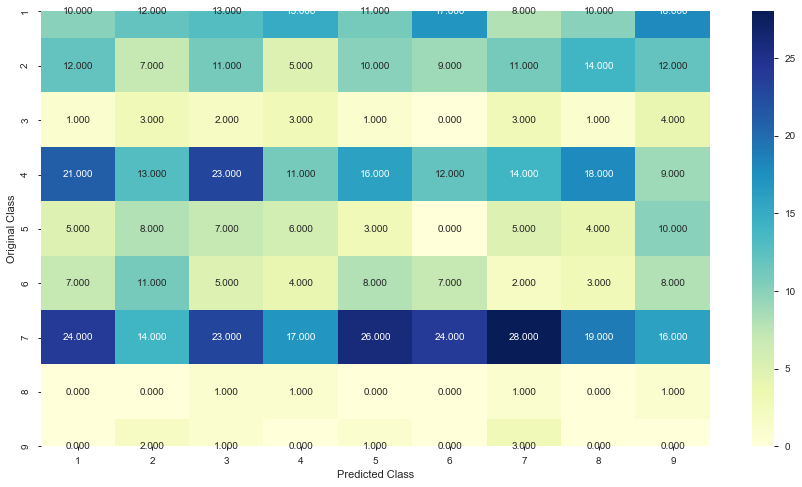

In [68]:
label = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(15,8))
sns.heatmap(conf_matrix, annot=True,cmap="YlGnBu", fmt=".3f", xticklabels=label, yticklabels=label )
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

##### Precision matrix

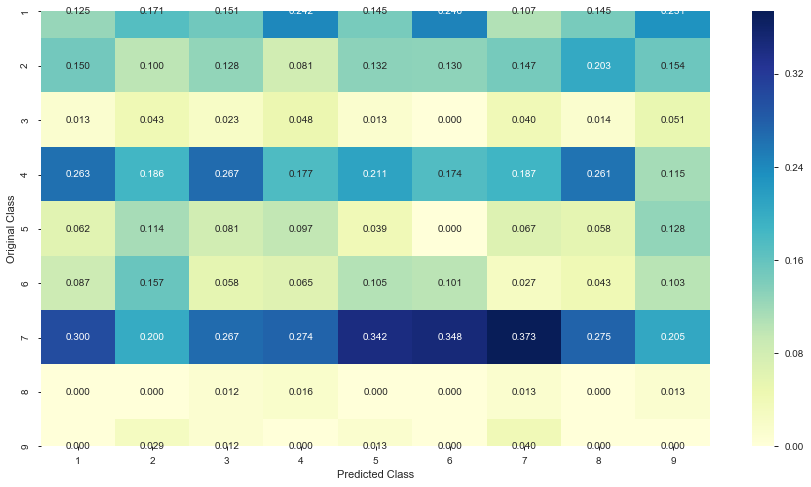

In [69]:
per_matrix = (conf_matrix/conf_matrix.sum(axis = 0))
label = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(15,8))
sns.heatmap(per_matrix, annot=True,cmap="YlGnBu", fmt=".3f", xticklabels=label, yticklabels=label )
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

##### Recall matrix

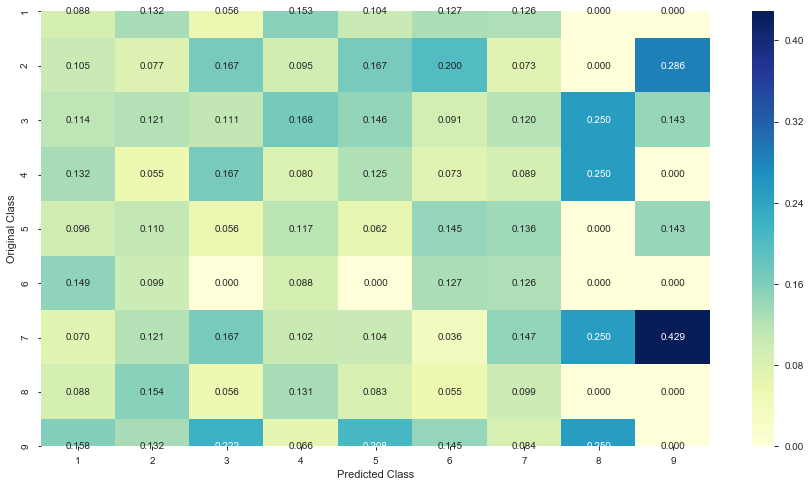

In [70]:
recall_matrix = ((conf_matrix.T)/(conf_matrix.sum(axis=1)).T)
label = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(15,8))
sns.heatmap(recall_matrix, annot=True,cmap="YlGnBu", fmt=".3f", xticklabels=label, yticklabels=label )
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

#### Evaluating Gene Column

BRCA1    154
TP53     104
EGFR      89
PTEN      88
BRCA2     83
Name: Gene, dtype: int64


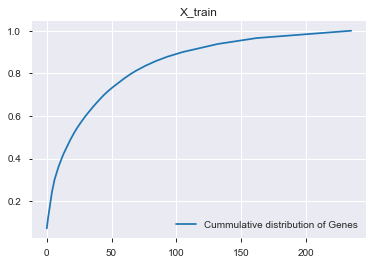

BRCA1    62
TP53     33
EGFR     26
KIT      24
BRCA2    23
Name: Gene, dtype: int64


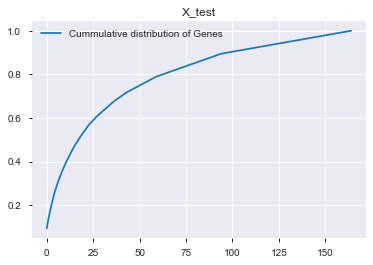

BRCA1    48
EGFR     26
TP53     26
PTEN     21
BRCA2    19
Name: Gene, dtype: int64


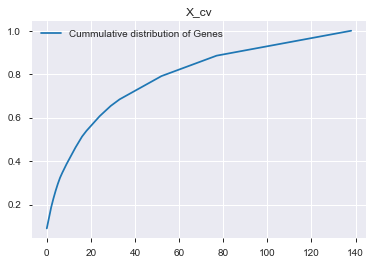

In [71]:
tab = {'X_train':X_train ,'X_test' : X_test, 'X_cv': X_cv}

for i,j in tab.items():
    gene_val = j['Gene'].value_counts()
    print(gene_val.head(5))
    gene_sum = sum(gene_val)
    h = gene_val.values/gene_sum
    c = np.cumsum(h)
    plt.plot(c, label = 'Cummulative distribution of Genes')
    plt.legend()
    plt.title(i)
    plt.show()

##### The above Gene distribution in  train, cv, test shows that top 50 genes contribute 75% of the genes

#### Converting these categorical variable to machine learning format

* One-hot encoding
* Response Encoding

##### Gene One-hot Encoding

In [72]:
from sklearn.feature_extraction.text import CountVectorizer

In [73]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(X_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(X_cv['Gene'])

##### Gene Response Encoding - with Laplace smoothing

**Response Encoding of a Gene is 

**Number of times that gene in specific class + (alpha*10)** / **total numb of times of gene in all classes + (alpha *90)**

In [74]:
def get_gv_fea_dict(alpha, feature, df):
    value_count = X_train[feature].value_counts()
    gv_dict = dict()
    
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = df.loc[(df['Class']==k) & (df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict

In [75]:
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = X_train[feature].value_counts()
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

In [76]:
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_train))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_test))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_cv))

#### Stochastic Gradient Descent (SGD)
Gradient descent is an optimization algorithm that starts optimization from a random parameter values (m & c in y = mX+c) of a function (SSR) and travels down its slope in steps until it reaches the lowest point of that function.

In both gradient descent (GD) and stochastic gradient descent (SGD), you update a set of parameters in an iterative manner to minimize an error function.
While in GD, you have to run through ALL the samples in your training set to do a single update for a parameter in a particular iteration, in SGD, on the other hand, you use ONLY ONE or SUBSET of training sample from your training set to do the update for a parameter in a particular iteration. If you use SUBSET, it is called Minibatch Stochastic gradient Descent

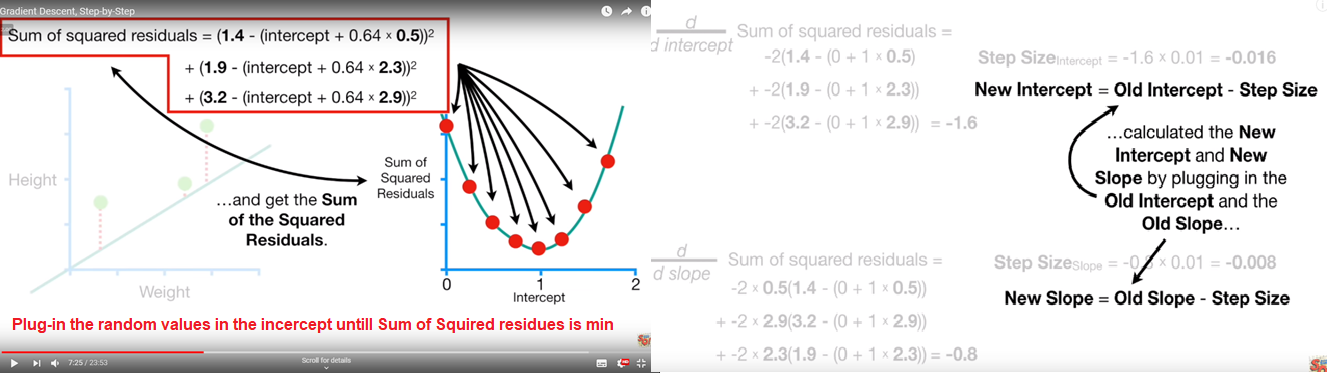
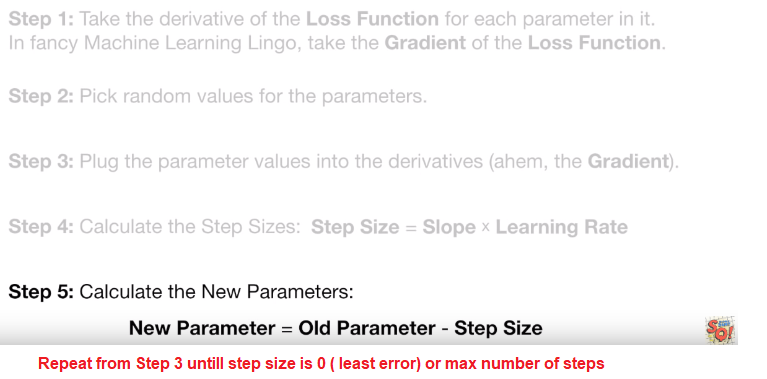

In [77]:
alpha = [10 ** x for x in range(-5, 1)]
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1]

In [78]:
#CalibratedClassifierCV - helps to convert the result into probabilty format

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.185472648648076
For values of alpha =  0.0001 The log loss is: 1.1621096318557051
For values of alpha =  0.001 The log loss is: 1.19774601518524
For values of alpha =  0.01 The log loss is: 1.3308151059787492
For values of alpha =  0.1 The log loss is: 1.4364936287285168
For values of alpha =  1 The log loss is: 1.4689864289755674


In [79]:
best_alpha = alpha[np.argmin(cv_log_error_array)]
best_alpha

0.0001

In [80]:
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log',random_state=42 )
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('The log_loss is {} with the alpha {}'.format(log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15), best_alpha))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('The log_loss is {} with the alpha {}'.format(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15), best_alpha))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('The log_loss is {} with the alpha {}'.format(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15), best_alpha))


The log_loss is 0.9899404004917934 with the alpha 0.0001
The log_loss is 1.1621096318557051 with the alpha 0.0001
The log_loss is 1.2425986610671154 with the alpha 0.0001


#### Check Coverage

In [81]:
test_cov = X_test[X_test['Gene'].isin(X_train['Gene'])].shape[0]
cv_cov = X_cv[X_cv['Gene'].isin(X_train['Gene'])].shape[0]
print('Number of test genes in train data {} i.e {} %'.format(test_cov, test_cov/X_test.shape[0]) )
print('Number of cv genes in train data {} i.e {} %'.format(cv_cov, cv_cov/X_cv.shape[0]) )

Number of test genes in train data 642 i.e 0.9654135338345865 %
Number of cv genes in train data 523 i.e 0.9830827067669173 %


#### Evaluating Variation Column

Truncating_Mutations    66
Amplification           47
Deletion                42
Fusions                 23
Overexpression           4
Name: Variation, dtype: int64


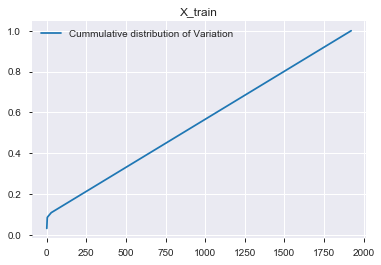

Deletion                17
Truncating_Mutations    15
Amplification            9
Fusions                  7
Overexpression           2
Name: Variation, dtype: int64


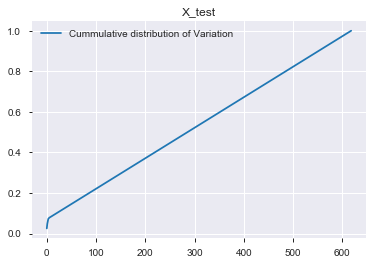

Deletion                15
Amplification           15
Truncating_Mutations    12
Fusions                  4
Q61R                     3
Name: Variation, dtype: int64


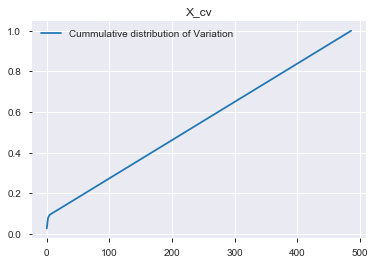

In [82]:
tab = {'X_train':X_train ,'X_test' : X_test, 'X_cv': X_cv}

for i,j in tab.items():
    var_val = j['Variation'].value_counts()
    print(var_val.head(5))
    var_sum = sum(var_val)
    h = var_val.values/var_sum
    c = np.cumsum(h)
    plt.plot(c, label = 'Cummulative distribution of Variation')
    plt.legend()
    plt.title(i)
    plt.show()

##### Variation one-hot encoding, Response Encoding

In [83]:
#one-hot Encoding

var_vectorizer = CountVectorizer()
train_var_onehotCoding = var_vectorizer.fit_transform(X_train['Variation'])
test_var_onehotCoding = var_vectorizer.transform(X_test['Variation'])
cv_var_onehotCoding = var_vectorizer.transform(X_cv['Variation'])


In [84]:
# Response Encoding
alpha = 1
train_var_responseCoding = np.array(get_gv_feature(alpha, 'Variation', X_train))
test_var_responseCoding = np.array(get_gv_feature(alpha, 'Variation', X_test))
cv_var_responseCoding = np.array(get_gv_feature(alpha, 'Variation', X_cv))

In [85]:
train_var_responseCoding.shape

(2124, 9)

In [86]:
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(loss='log',penalty='l2',alpha=i,random_state=42)
    clf.fit(train_var_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_var_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_var_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('The loss_loss {} for alpa  {}'.format(log_loss(y_cv,predict_y,labels=clf.classes_, eps=1e-15),i))


The loss_loss 1.7101045579949352 for alpa  1e-05
The loss_loss 1.7044949929454218 for alpa  0.0001
The loss_loss 1.7004198250578775 for alpa  0.001
The loss_loss 1.7034042373967373 for alpa  0.01
The loss_loss 1.7164006998475287 for alpa  0.1
The loss_loss 1.7167845913552022 for alpa  1


In [87]:
best_alpha = alpha[np.argmin(cv_log_error_array)]

clf = SGDClassifier(loss='log',penalty='l2',alpha=best_alpha,random_state=42)
clf.fit(train_var_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_var_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_var_onehotCoding)
print('The loss_loss of train {} for alpha  {}'.format(log_loss(y_train,predict_y,labels=clf.classes_, eps=1e-15), best_alpha))
predict_y = sig_clf.predict_proba(cv_var_onehotCoding)
print('The loss_loss of cv {} for alpha  {}'.format(log_loss(y_cv,predict_y,labels=clf.classes_, eps=1e-15), best_alpha))
predict_y = sig_clf.predict_proba(test_var_onehotCoding)
print('The loss_loss of test {} for alpha  {}'.format(log_loss(y_test,predict_y,labels=clf.classes_, eps=1e-15), best_alpha))


The loss_loss of train 1.1011098984576728 for alpha  0.001
The loss_loss of cv 1.7004198250578775 for alpha  0.001
The loss_loss of test 1.7302022802746744 for alpha  0.001


#### Evaluating Text column

In [88]:
# cls_text is a data frame
# for every row in data fram consider the 'Text'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['Text'].split():
            dictionary[word] +=1
    return dictionary

import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['Text'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['Text'].split()))
            row_index += 1
    return text_feature_responseCoding

# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(X_train['Text'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = X_train[X_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(X_train)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(X_train)
test_text_feature_responseCoding  = get_text_responsecoding(X_test)
cv_text_feature_responseCoding  = get_text_responsecoding(X_cv)

# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(X_test['Text'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(X_cv['Text'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

# Number of words for a given frequency.
print(Counter(sorted_text_occur))

#Lets build the model with only ***text*** column

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


#Lets check the overlap of text data

def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['Text'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

len1,len2 = get_intersec_text(X_test)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(X_cv)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")


Total number of unique words in train data : 53295
Counter({3: 5561, 4: 3532, 6: 2615, 5: 2500, 7: 2263, 8: 2001, 9: 1840, 10: 1376, 12: 1146, 13: 1122, 11: 1100, 15: 960, 14: 906, 16: 896, 18: 752, 21: 686, 17: 625, 20: 596, 19: 532, 22: 493, 24: 467, 30: 393, 23: 379, 25: 368, 27: 348, 28: 341, 41: 337, 26: 318, 32: 315, 36: 307, 31: 303, 33: 284, 47: 279, 34: 268, 29: 266, 35: 247, 37: 212, 40: 210, 42: 203, 45: 196, 48: 185, 39: 184, 44: 183, 43: 182, 50: 180, 38: 166, 54: 162, 55: 156, 51: 154, 46: 154, 52: 151, 49: 149, 56: 139, 60: 135, 53: 132, 66: 130, 61: 126, 58: 126, 64: 124, 63: 118, 57: 110, 67: 108, 59: 107, 62: 105, 72: 104, 74: 103, 68: 102, 84: 98, 70: 97, 65: 95, 80: 91, 73: 90, 69: 90, 77: 83, 94: 79, 88: 79, 83: 77, 82: 74, 71: 74, 86: 73, 81: 73, 76: 72, 91: 71, 85: 71, 75: 71, 100: 70, 90: 69, 78: 65, 99: 64, 105: 62, 92: 62, 87: 62, 95: 61, 126: 59, 96: 59, 93: 59, 98: 58, 111: 57, 97: 56, 101: 53, 89: 53, 79: 53, 135: 52, 109: 52, 110: 50, 106: 50, 125: 49, 107

For values of alpha =  1e-05 The log loss is: 1.2935082083701743
For values of alpha =  0.0001 The log loss is: 1.1552972213310915
For values of alpha =  0.001 The log loss is: 1.1469172786011532
For values of alpha =  0.01 The log loss is: 1.197560774417296
For values of alpha =  0.1 The log loss is: 1.4476055322242218
For values of alpha =  1 The log loss is: 1.6591728668038435
For values of best alpha =  0.001 The train log loss is: 0.6905207913371813
For values of best alpha =  0.001 The cross validation log loss is: 1.1469172786011532
For values of best alpha =  0.001 The test log loss is: 1.3185916339066133
96.282 % of word of test data appeared in train data
97.561 % of word of Cross Validation appeared in train data


#### Data prepration for Machine Learning models

In [89]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

#### Combining all 3 features together

In [90]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_var_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_var_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_var_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(X_train['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(X_test['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(X_cv['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_var_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_var_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_var_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [91]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55483)
(number of data points * number of features) in test data =  (665, 55483)
(number of data points * number of features) in cross validation data = (532, 55483)
 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


### Building Machine Learning model

In [92]:
ml_algo_results = pd.DataFrame(columns=['algo','train_log_loss', 'cv_log_loss', 'test_log_loss','mis_classfication' ])
ml_algo_results

Empty DataFrame
Columns: [algo, train_log_loss, cv_log_loss, test_log_loss, mis_classfication]
Index: []

#### Naive Bayes

In [93]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print('Alpha is ', i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

Alpha is  1e-05
Log Loss : 1.2760964102074757
Alpha is  0.0001
Log Loss : 1.2707316033888743
Alpha is  0.001
Log Loss : 1.2532172446089493
Alpha is  0.1
Log Loss : 1.2542307135626818
Alpha is  1
Log Loss : 1.2821816571831497
Alpha is  10
Log Loss : 1.3675274659264216
Alpha is  100
Log Loss : 1.3630808101524217
Alpha is  1000
Log Loss : 1.316518081032255


In [94]:
best_alpha = alpha[np.argmin(cv_log_error_array)]
clf = MultinomialNB(alpha=best_alpha)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_onehotCoding, y_train)

sig_clf_probs = sig_clf.predict_proba(train_x_onehotCoding)
nb_train_ll = log_loss(train_y, sig_clf_probs)
print('For values of best alpha = ', best_alpha, "Train Log Loss :",nb_train_ll) 

sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
nb_cv_ll = log_loss(cv_y, sig_clf_probs)
print('For values of best alpha = ', best_alpha,"cv Log Loss :",nb_cv_ll)

sig_clf_probs = sig_clf.predict_proba(test_x_onehotCoding)
nb_test_ll = log_loss(test_y, sig_clf_probs)
print('For values of best alpha = ', best_alpha,"Test Log Loss :",nb_test_ll)


For values of best alpha =  0.001 Train Log Loss : 0.8522306216802064
For values of best alpha =  0.001 cv Log Loss : 1.2532172446089493
For values of best alpha =  0.001 Test Log Loss : 1.361984127183432


Number of missclassified point : 0.38721804511278196
-------------------- Confusion matrix --------------------


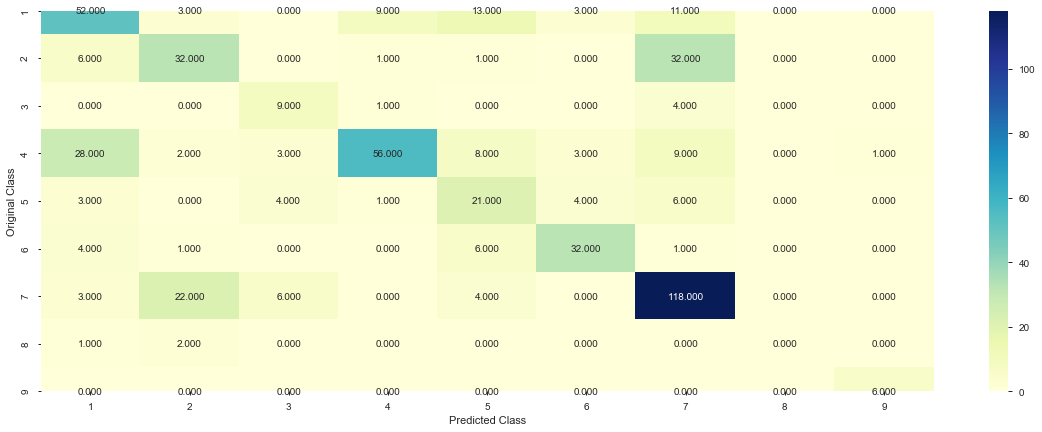

-------------------- Precision matrix (Columm Sum=1) --------------------


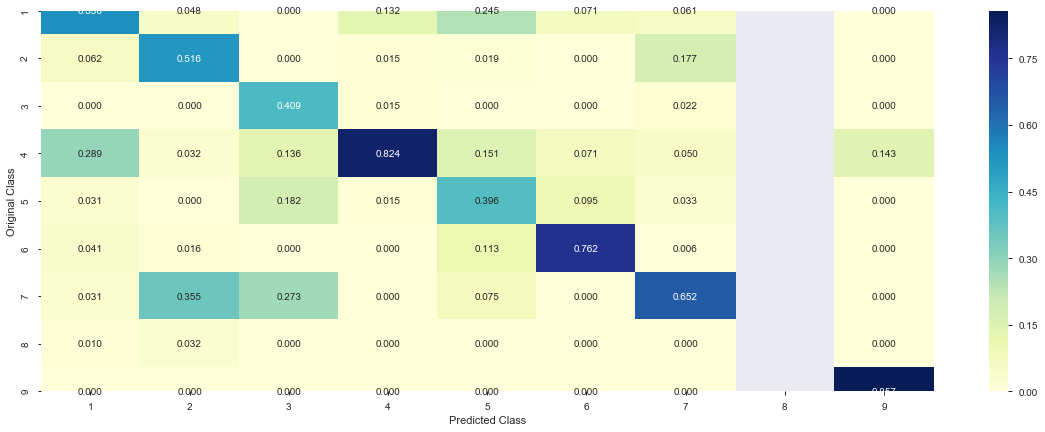

-------------------- Recall matrix (Row sum=1) --------------------


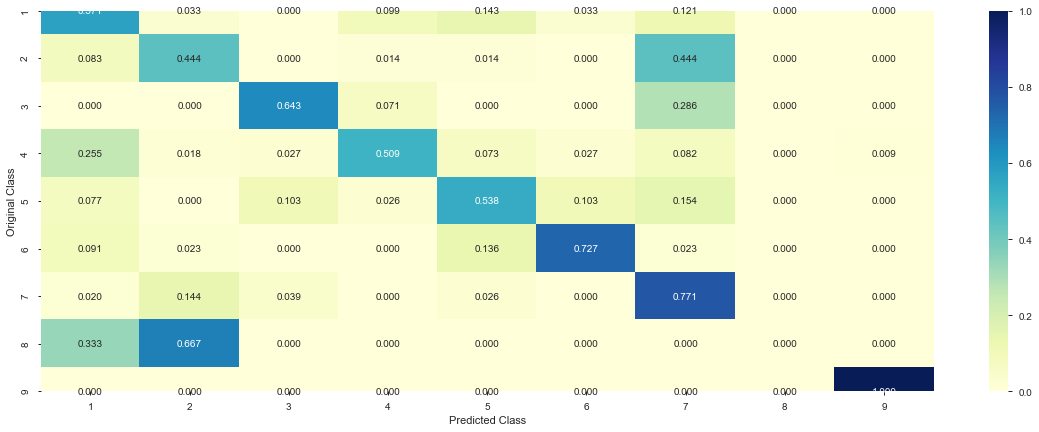

In [95]:
nb_mis_cla = np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0]
print("Number of missclassified point :", nb_mis_cla)
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [96]:
ml_algo_results = ml_algo_results.append({'algo': 'Naive','train_log_loss' : nb_train_ll, 'cv_log_loss': nb_cv_ll, 'test_log_loss': nb_test_ll, 'mis_classfication' : nb_mis_cla}, ignore_index=True)
ml_algo_results

algo  train_log_loss  cv_log_loss  test_log_loss  mis_classfication
0  Naive        0.852231     1.253217       1.361984           0.387218

#### K Nearest Neighbour Classification

In [97]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 5
Log Loss : 1.1948658338413982
for alpha = 11
Log Loss : 1.1896677570486982
for alpha = 15
Log Loss : 1.1629206864687458
for alpha = 21
Log Loss : 1.122314651880239
for alpha = 31
Log Loss : 1.1200718515805659
for alpha = 41
Log Loss : 1.1580189977994302
for alpha = 51
Log Loss : 1.1856658963773947
for alpha = 99
Log Loss : 1.2613870298877454


In [98]:
best_alpha = alpha[np.argmin(cv_log_error_array)]
clf = KNeighborsClassifier(n_neighbors=best_alpha)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_onehotCoding, y_train)
sig_clf_probs = sig_clf.predict_proba(train_x_onehotCoding)
knn_train_ll = log_loss(train_y, sig_clf_probs)
print('For values of best alpha = ', best_alpha, "Train Log Loss :",knn_train_ll) 
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
knn_cv_ll = log_loss(cv_y, sig_clf_probs)
print('For values of best alpha = ', best_alpha,"cv Log Loss :",knn_cv_ll)
sig_clf_probs = sig_clf.predict_proba(test_x_onehotCoding)
knn_test_ll = log_loss(test_y, sig_clf_probs)
print('For values of best alpha = ', best_alpha,"Test Log Loss :",knn_test_ll)

For values of best alpha =  31 Train Log Loss : 1.291882516479703
For values of best alpha =  31 cv Log Loss : 1.411247066650725
For values of best alpha =  31 Test Log Loss : 1.4911961722814073


Number of missclassified point : 0.4605263157894737
-------------------- Confusion matrix --------------------


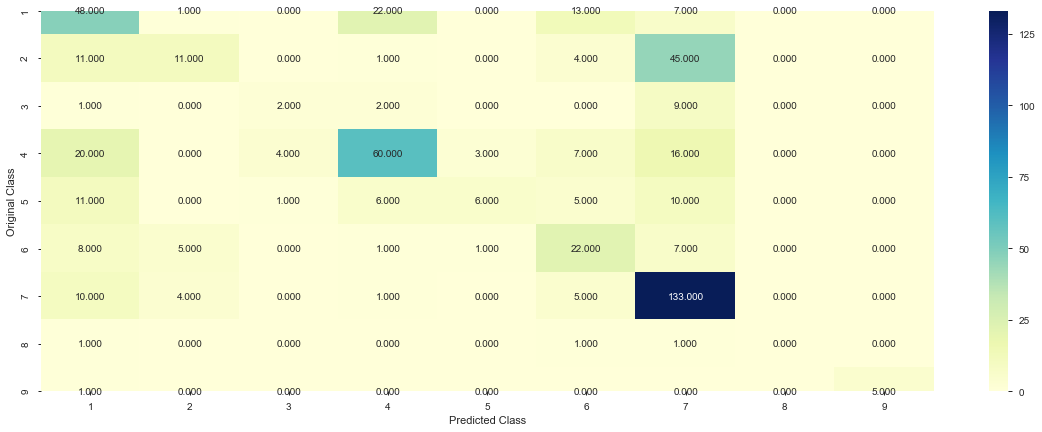

-------------------- Precision matrix (Columm Sum=1) --------------------


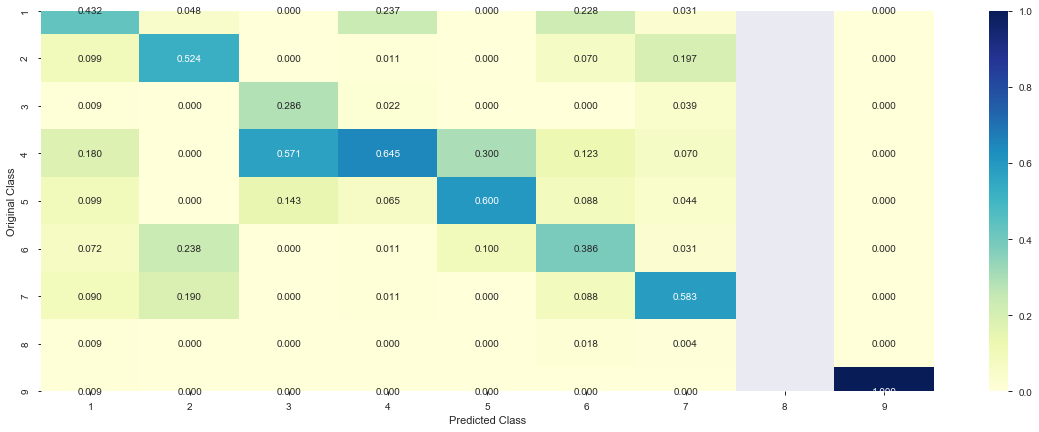

-------------------- Recall matrix (Row sum=1) --------------------


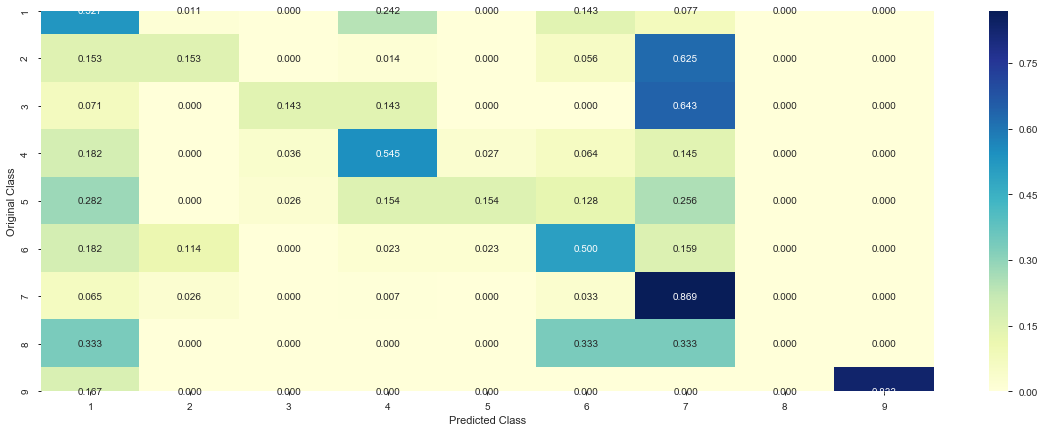

In [99]:
knn_mis_cla = np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0]
print("Number of missclassified point :", knn_mis_cla)
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [100]:
ml_algo_results = ml_algo_results.append({'algo': 'knn','train_log_loss' : knn_train_ll, 'cv_log_loss': knn_cv_ll, 'test_log_loss': knn_test_ll, 'mis_classfication' : knn_mis_cla}, ignore_index=True)
ml_algo_results

algo  train_log_loss  cv_log_loss  test_log_loss  mis_classfication
0  Naive        0.852231     1.253217       1.361984           0.387218
1    knn        1.291883     1.411247       1.491196           0.460526

#### Logistic Regression - With Balanced

In [101]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-06
Log Loss : 1.3162627753117773
for alpha = 1e-05
Log Loss : 1.2872752446073343
for alpha = 0.0001
Log Loss : 1.08971057613423
for alpha = 0.001
Log Loss : 1.049925417814469
for alpha = 0.01
Log Loss : 1.0868260955759903
for alpha = 0.1
Log Loss : 1.446155015871175
for alpha = 1
Log Loss : 1.7124571907990545
for alpha = 10
Log Loss : 1.744278877131703
for alpha = 100
Log Loss : 1.7474439551953853


In [102]:
best_alpha = alpha[np.argmin(cv_log_error_array)]
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_onehotCoding, y_train)
sig_clf_probs = sig_clf.predict_proba(train_x_onehotCoding)
log_reg_train_ll = log_loss(train_y, sig_clf_probs)
print('For values of best alpha = ', best_alpha, "Train Log Loss :",log_reg_train_ll) 
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
log_reg_cv_ll = log_loss(cv_y, sig_clf_probs)
print('For values of best alpha = ', best_alpha,"cv Log Loss :",log_reg_cv_ll)
sig_clf_probs = sig_clf.predict_proba(test_x_onehotCoding)
log_reg_test_ll = log_loss(test_y, sig_clf_probs)
print('For values of best alpha = ', best_alpha,"Test Log Loss :",log_reg_test_ll)

For values of best alpha =  0.001 Train Log Loss : 0.55305189541723
For values of best alpha =  0.001 cv Log Loss : 1.049925417814469
For values of best alpha =  0.001 Test Log Loss : 1.257492964423702


Number of missclassified point : 0.34022556390977443
-------------------- Confusion matrix --------------------


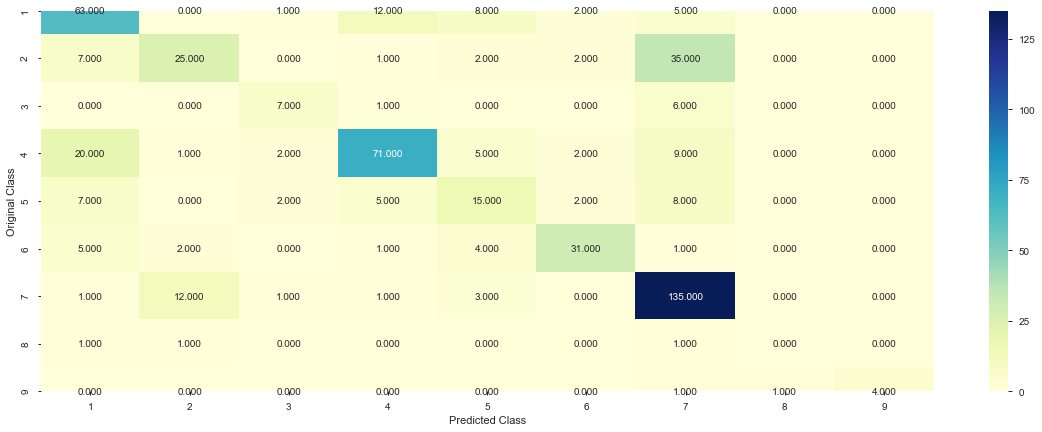

-------------------- Precision matrix (Columm Sum=1) --------------------


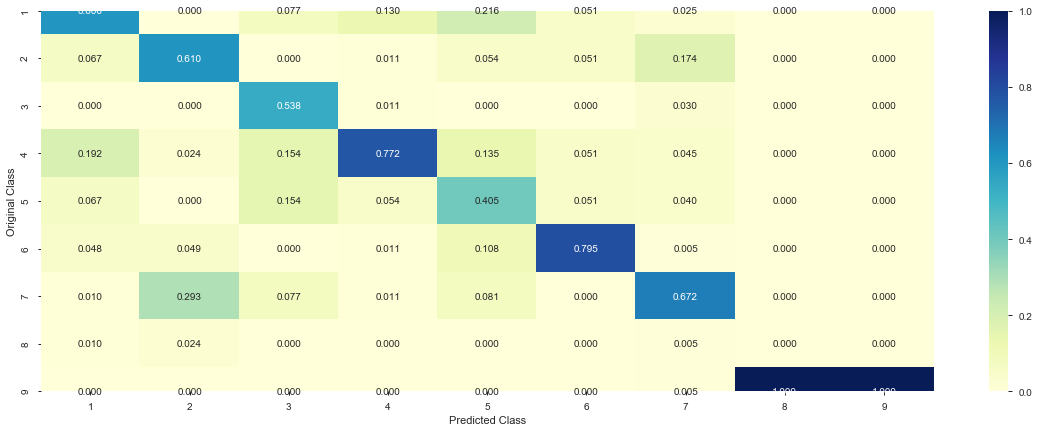

-------------------- Recall matrix (Row sum=1) --------------------


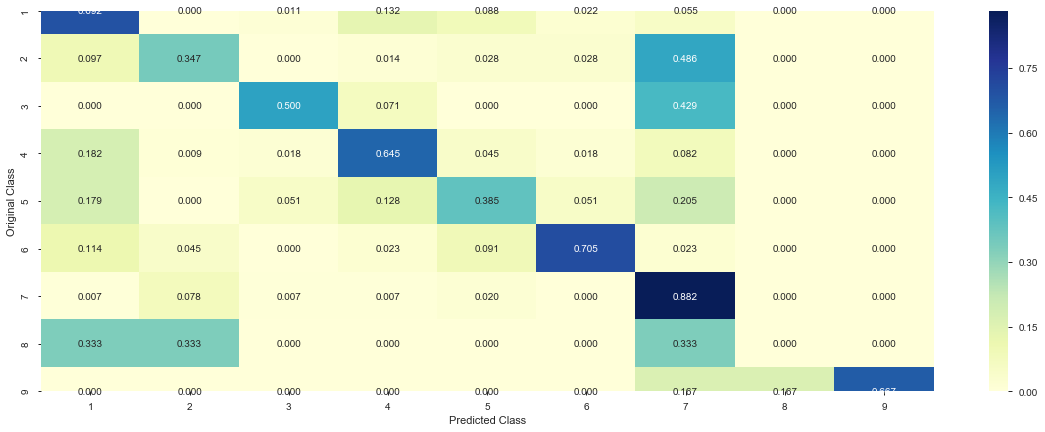

algo  train_log_loss  cv_log_loss  test_log_loss  mis_classfication
0         Naive        0.852231     1.253217       1.361984           0.387218
1           knn        1.291883     1.411247       1.491196           0.460526
2  logistic_reg        0.553052     1.049925       1.257493           0.340226

In [103]:
log_reg_mis_cla = np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0]
print("Number of missclassified point :", log_reg_mis_cla)
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

ml_algo_results = ml_algo_results.append({'algo': 'logistic_reg','train_log_loss' : log_reg_train_ll, 'cv_log_loss': log_reg_cv_ll, 'test_log_loss': log_reg_test_ll, 'mis_classfication' : log_reg_mis_cla}, ignore_index=True)
ml_algo_results

#### Logistic Regression - Without Balanced

for alpha = 1e-06
Log Loss : 1.2998582744630724
for alpha = 1e-05
Log Loss : 1.2692885667532905
for alpha = 0.0001
Log Loss : 1.1100238618369118
for alpha = 0.001
Log Loss : 1.0824359927126594
for alpha = 0.01
Log Loss : 1.1277137487285545
for alpha = 0.1
Log Loss : 1.3552357168812934
for alpha = 1
Log Loss : 1.611851847489506
for alpha = 10
Log Loss : 1.648594394744387
for alpha = 100
Log Loss : 1.6525432680817487
For values of best alpha =  0.001 Train Log Loss : 0.5499593070938077
For values of best alpha =  0.001 cv Log Loss : 1.0824359927126594
For values of best alpha =  0.001 Test Log Loss : 1.2599764458885154
Number of missclassified point : 0.33646616541353386
-------------------- Confusion matrix --------------------


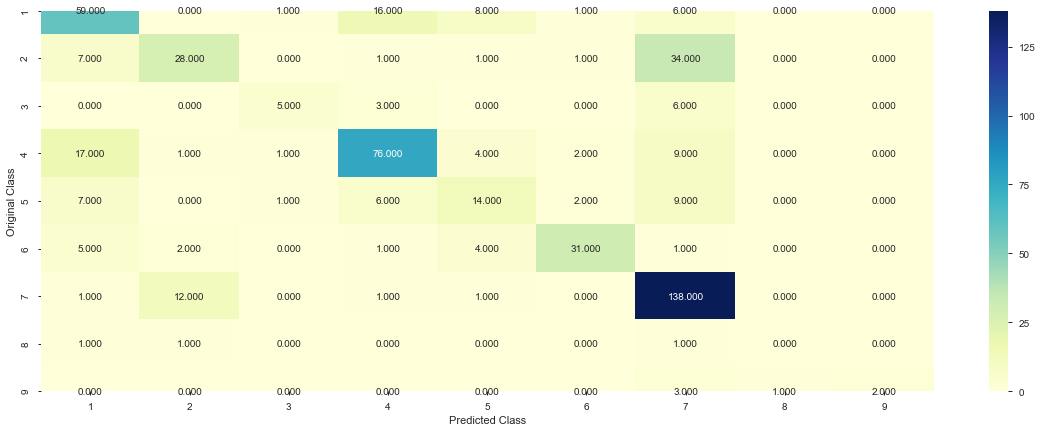

-------------------- Precision matrix (Columm Sum=1) --------------------


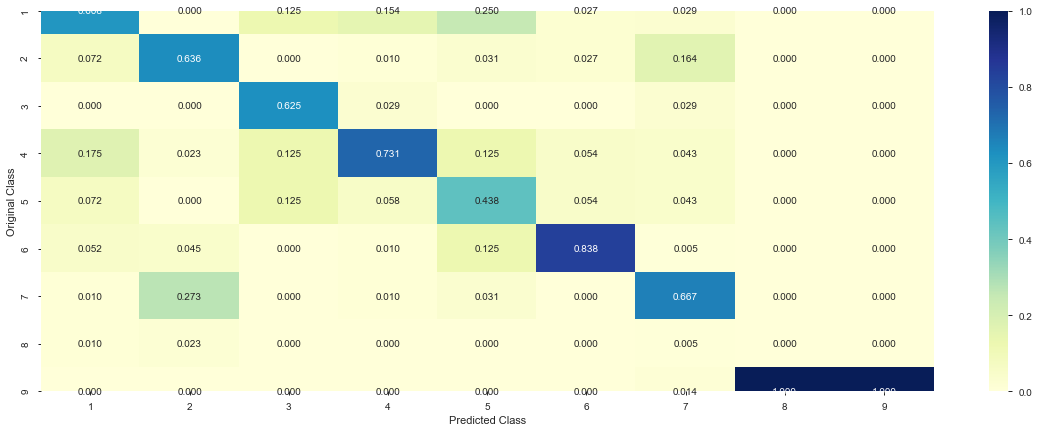

-------------------- Recall matrix (Row sum=1) --------------------


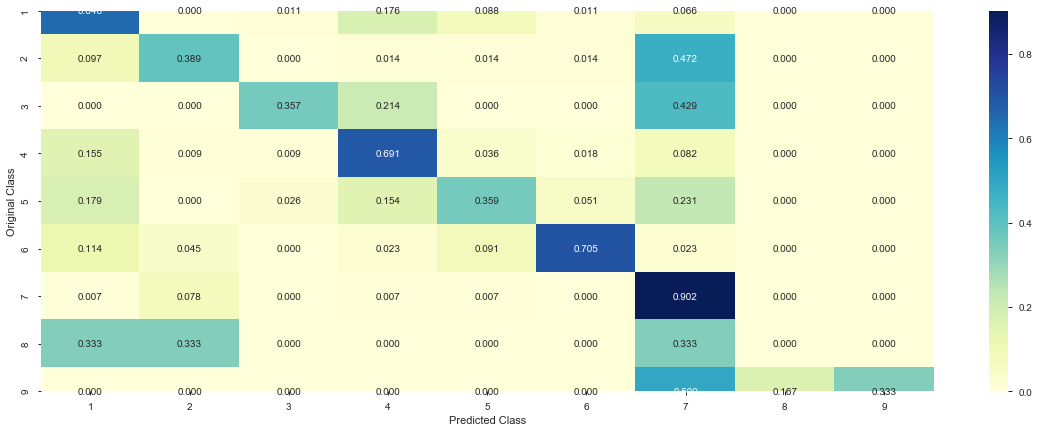

algo  train_log_loss  cv_log_loss  test_log_loss  \
0                Naive        0.852231     1.253217       1.361984   
1                  knn        1.291883     1.411247       1.491196   
2         logistic_reg        0.553052     1.049925       1.257493   
3  logistic_reg_no_bal        0.549959     1.082436       1.259976   

   mis_classfication  
0           0.387218  
1           0.460526  
2           0.340226  
3           0.336466

In [104]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = alpha[np.argmin(cv_log_error_array)]
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_onehotCoding, y_train)
sig_clf_probs = sig_clf.predict_proba(train_x_onehotCoding)
log_reg_train_ll = log_loss(train_y, sig_clf_probs)
print('For values of best alpha = ', best_alpha, "Train Log Loss :",log_reg_train_ll) 
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
log_reg_cv_ll = log_loss(cv_y, sig_clf_probs)
print('For values of best alpha = ', best_alpha,"cv Log Loss :",log_reg_cv_ll)
sig_clf_probs = sig_clf.predict_proba(test_x_onehotCoding)
log_reg_test_ll = log_loss(test_y, sig_clf_probs)
print('For values of best alpha = ', best_alpha,"Test Log Loss :",log_reg_test_ll)

log_reg_mis_cla = np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0]
print("Number of missclassified point :", log_reg_mis_cla)
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

ml_algo_results = ml_algo_results.append({'algo': 'logistic_reg_no_bal','train_log_loss' : log_reg_train_ll, 'cv_log_loss': log_reg_cv_ll, 'test_log_loss': log_reg_test_ll, 'mis_classfication' : log_reg_mis_cla}, ignore_index=True)
ml_algo_results

for alpha = 1e-06
Log Loss : 1.2978834222352615
for alpha = 1e-05
Log Loss : 1.2726373087076777
for alpha = 0.0001
Log Loss : 1.2152278570206647
for alpha = 0.001
Log Loss : 1.1078830985314612
for alpha = 0.01
Log Loss : 1.114014785474728
for alpha = 0.1
Log Loss : 1.3134691785696957
for alpha = 1
Log Loss : 1.731824989783771
for alpha = 10
Log Loss : 1.7479138055873207
for alpha = 100
Log Loss : 1.7479148781107663
For values of best alpha =  0.001 Train Log Loss : 0.5766065550185331
For values of best alpha =  0.001 cv Log Loss : 1.1078830985314612
For values of best alpha =  0.001 Test Log Loss : 1.254691447531085
Number of missclassified point : 0.35902255639097747
-------------------- Confusion matrix --------------------


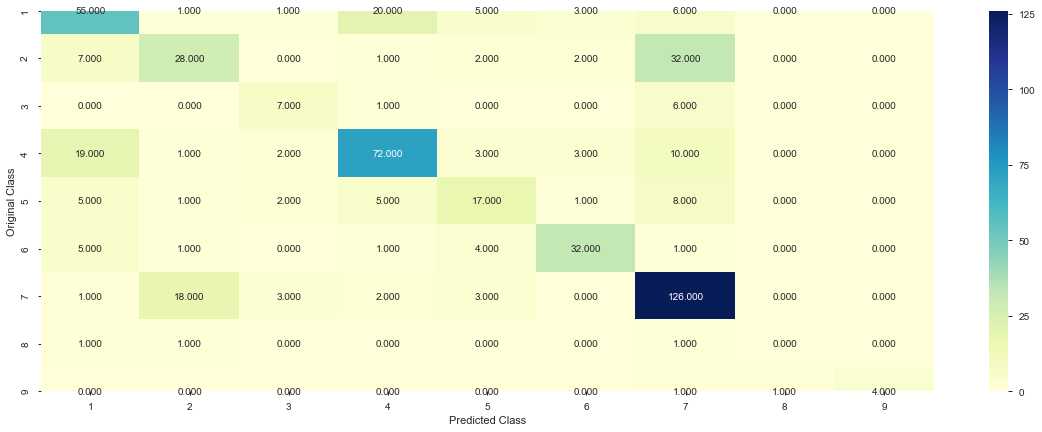

-------------------- Precision matrix (Columm Sum=1) --------------------


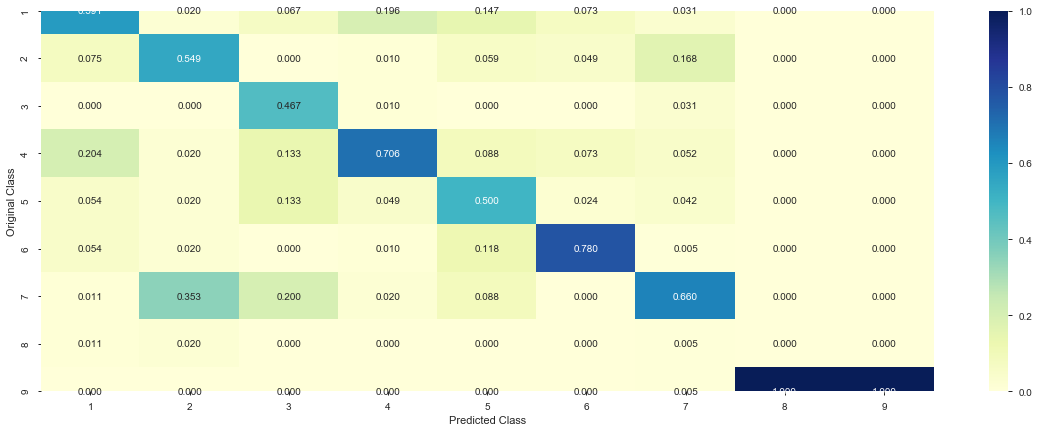

-------------------- Recall matrix (Row sum=1) --------------------


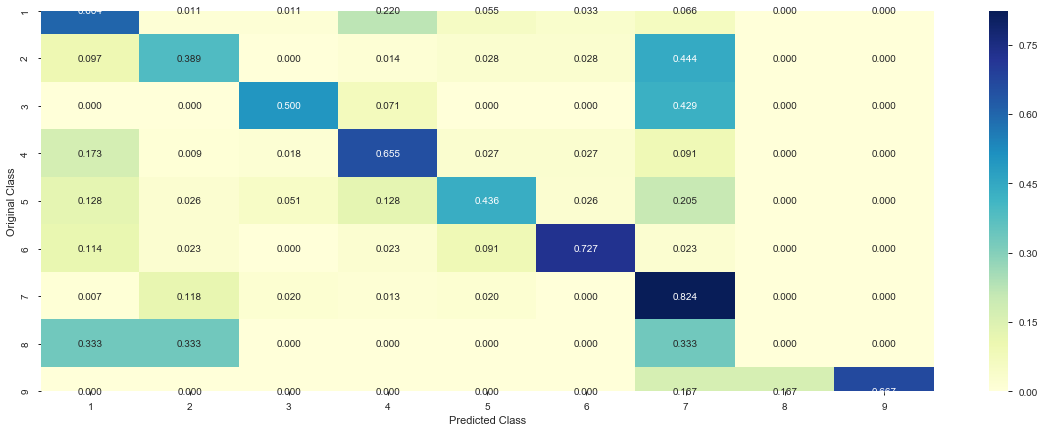

algo  train_log_loss  cv_log_loss  test_log_loss  \
0                Naive        0.852231     1.253217       1.361984   
1                  knn        1.291883     1.411247       1.491196   
2         logistic_reg        0.553052     1.049925       1.257493   
3  logistic_reg_no_bal        0.549959     1.082436       1.259976   
4                  svm        0.576607     1.107883       1.254691   

   mis_classfication  
0           0.387218  
1           0.460526  
2           0.340226  
3           0.336466  
4           0.359023

In [105]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced',alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = alpha[np.argmin(cv_log_error_array)]
clf = SGDClassifier(class_weight='balanced',alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_onehotCoding, y_train)
sig_clf_probs = sig_clf.predict_proba(train_x_onehotCoding)
svm_train_ll = log_loss(train_y, sig_clf_probs)
print('For values of best alpha = ', best_alpha, "Train Log Loss :",svm_train_ll) 
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
svm_cv_ll = log_loss(cv_y, sig_clf_probs)
print('For values of best alpha = ', best_alpha,"cv Log Loss :",svm_cv_ll)
sig_clf_probs = sig_clf.predict_proba(test_x_onehotCoding)
svm_test_ll = log_loss(test_y, sig_clf_probs)
print('For values of best alpha = ', best_alpha,"Test Log Loss :",svm_test_ll)

svm_mis_cla = np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0]
print("Number of missclassified point :", svm_mis_cla)
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

ml_algo_results = ml_algo_results.append({'algo': 'svm','train_log_loss' : svm_train_ll, 'cv_log_loss': svm_cv_ll, 'test_log_loss': svm_test_ll, 'mis_classfication' : svm_mis_cla}, ignore_index=True)
ml_algo_results

#### Random Forest Classifier

In [106]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for n_estimators = 100 and max depth =  5
Log Loss : 1.230001352090593
for n_estimators = 100 and max depth =  10
Log Loss : 1.1530503758594621
for n_estimators = 200 and max depth =  5
Log Loss : 1.2141034829871251
for n_estimators = 200 and max depth =  10
Log Loss : 1.1481628047872605
for n_estimators = 500 and max depth =  5
Log Loss : 1.1962895371010962
for n_estimators = 500 and max depth =  10
Log Loss : 1.1373877414591482
for n_estimators = 1000 and max depth =  5
Log Loss : 1.1963984734564153
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1338434641223458
for n_estimators = 2000 and max depth =  5
Log Loss : 1.197452487339519
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1365845440698221


For values of best alpha =  1000 Train Log Loss : 0.7023241708063319
For values of best alpha =  1000 cv Log Loss : 1.133843464122346
For values of best alpha =  1000 Test Log Loss : 1.229100940452129
Log loss : 1.133843464122346
Number of mis-classified points : 0.41541353383458646
-------------------- Confusion matrix --------------------


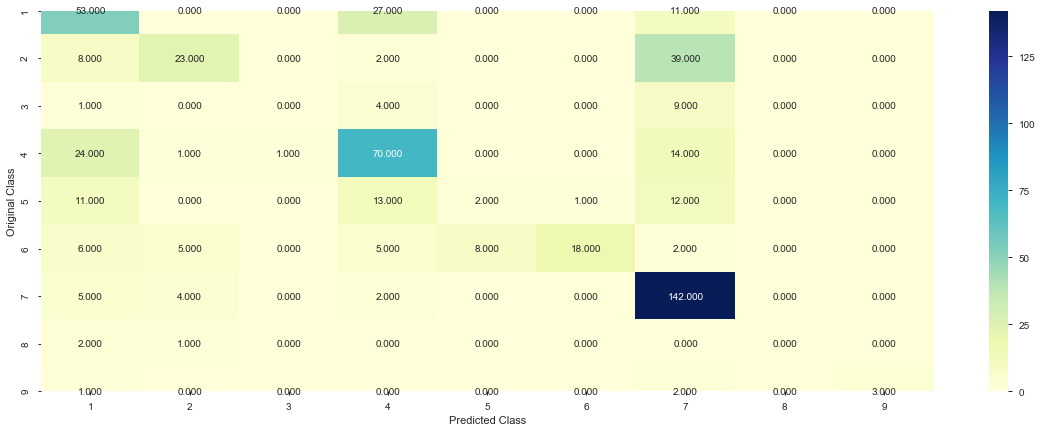

-------------------- Precision matrix (Columm Sum=1) --------------------


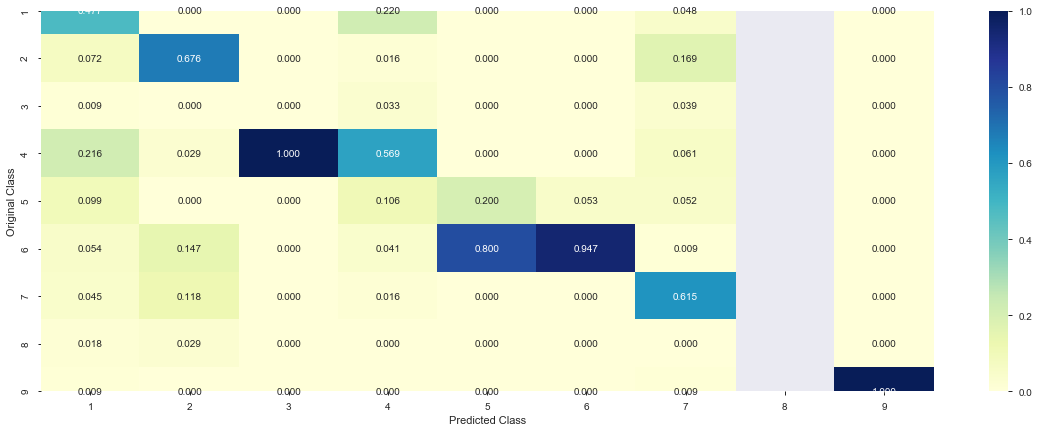

-------------------- Recall matrix (Row sum=1) --------------------


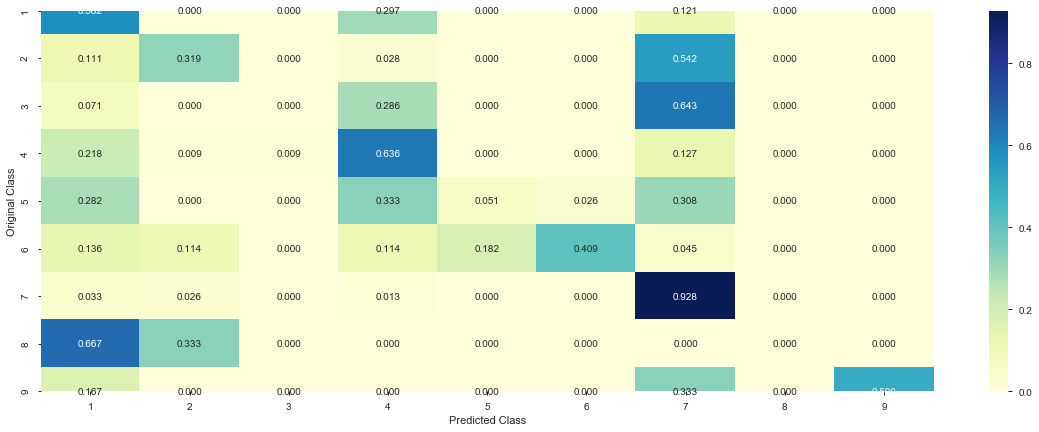

In [107]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_onehotCoding, y_train)
sig_clf_probs = sig_clf.predict_proba(train_x_onehotCoding)
rf_train_ll = log_loss(train_y, sig_clf_probs)
print('For values of best alpha = ', alpha[int(best_alpha/2)], "Train Log Loss :", rf_train_ll ) 
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
rf_cv_ll = log_loss(cv_y, sig_clf_probs)
print('For values of best alpha = ', alpha[int(best_alpha/2)],"cv Log Loss :",rf_cv_ll)
sig_clf_probs = sig_clf.predict_proba(test_x_onehotCoding)
rf_test_ll = log_loss(test_y, sig_clf_probs)
print('For values of best alpha = ', alpha[int(best_alpha/2)],"Test Log Loss :",rf_test_ll)

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [108]:
rf_mis_cla = np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0]
print("Number of missclassified point :", rf_mis_cla)

Number of missclassified point : 0.41541353383458646


In [109]:
ml_algo_results = ml_algo_results.append({'algo': 'Random forest','train_log_loss' : rf_train_ll, 'cv_log_loss': rf_cv_ll, 'test_log_loss': rf_test_ll, 'mis_classfication' : rf_mis_cla}, ignore_index=True)
ml_algo_results

algo  train_log_loss  cv_log_loss  test_log_loss  \
0                Naive        0.852231     1.253217       1.361984   
1                  knn        1.291883     1.411247       1.491196   
2         logistic_reg        0.553052     1.049925       1.257493   
3  logistic_reg_no_bal        0.549959     1.082436       1.259976   
4                  svm        0.576607     1.107883       1.254691   
5        Random forest        0.702324     1.133843       1.229101   

   mis_classfication  
0           0.387218  
1           0.460526  
2           0.340226  
3           0.336466  
4           0.359023  
5           0.415414

**From all the above Machine Learning Results Logistic Regression given the best Results of Log_Loss 1.257**